# Initialization



## Import librairies

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit, minimize
from scipy.stats import t

import emcee

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, StratifiedGroupKFold, KFold, GroupKFold,LeaveOneGroupOut
from sklearn.metrics import auc,roc_curve,confusion_matrix, precision_score, recall_score, f1_score,accuracy_score, make_scorer

import tensorflow as tf
from keras.regularizers import l2

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble  import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier



## Init folder input/output paths

In [2]:
def createFolder(folder_path):
    folder_path = Path(folder_path)
    folder_path.mkdir(parents=True, exist_ok=True)

fig_folder = Path('output figures')
createFolder(fig_folder)

## Load dataset

In [3]:
folder_dataset_processed = Path('data/processed_data')

df_A673 = pd.read_csv(folder_dataset_processed / 'A673_processed_data.csv', index_col=0)
df_PDX = pd.read_csv(folder_dataset_processed / 'PDX_processed_data.csv', index_col=0)

df_A673
#df_PDX

,spheroid ID,Experiment ID,drug concentration (uM),spheroIndex,Area (um2)_day0,Area (um2)_day1,Area (um2)_day2,Mean grey value_day0,Mean grey value_day1,Mean grey value_day2,...,Grey2-0,Grey2-1,DCorrelation_1-0,DCorrelation_2-0,DCorrelation_2-1,viability score,2 classes,2 classes encoded,3 classes,3 classes encoded
0,"(1803, 2, 0.1)",1803,0.1,2,21010.765200,NaN,40799.3564,273.563070,NaN,363.215620,...,89.652550,NaN,NaN,0.014911,NaN,78.738935,alive,0,alive,0
1,"(1803, 3, 0.1)",1803,0.1,3,18284.785800,30485.2706,41872.7440,446.811893,477.670048,357.425043,...,-89.386850,-120.245005,0.008844,0.027155,0.018311,81.441218,alive,0,alive,0
2,"(1803, 4, 0.1)",1803,0.1,4,15930.772400,27041.9282,NaN,233.473857,386.175899,NaN,...,NaN,NaN,0.007834,NaN,NaN,103.152664,alive,0,alive,0
3,"(1803, 5, 0.1)",1803,0.1,5,18412.317000,27653.0152,42882.3660,316.993179,370.756607,350.027196,...,33.034017,-20.729411,0.028224,0.028457,0.000233,76.813170,alive,0,alive,0
4,"(1803, 6, 0.1)",1803,0.1,6,15771.358400,26930.3384,41112.8706,311.382544,334.841864,466.537552,...,155.155008,131.695688,0.005906,-0.002487,-0.008393,73.893462,alive,0,middle,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,"(2901, 6, 20.0)",2901,20.0,6,18838.827310,NaN,23247.8750,346.617821,NaN,1069.836070,...,723.218249,NaN,NaN,-0.060875,NaN,42.281003,dead,1,middle,2
348,"(2901, 11, 20.0)",2901,20.0,11,19408.304872,NaN,27647.7014,242.379733,NaN,1047.332597,...,804.952864,NaN,NaN,-0.054548,NaN,34.153426,dead,1,middle,2
349,"(2901, 18, 20.0)",2901,20.0,18,17977.776798,NaN,21930.0526,306.838603,NaN,924.446711,...,617.608107,NaN,NaN,-0.039745,NaN,44.481610,dead,1,middle,2
350,"(2901, 12, 50.0)",2901,50.0,12,14365.307914,NaN,16345.2488,305.499310,NaN,1027.062685,...,721.563375,NaN,NaN,-0.061309,NaN,4.012441,dead,1,dead,1


In [4]:
df_A673.columns

Index(['spheroid ID', 'Experiment ID', 'drug concentration (uM)',
       'spheroIndex', 'Area (um2)_day0', 'Area (um2)_day1', 'Area (um2)_day2',
       'Mean grey value_day0', 'Mean grey value_day1', 'Mean grey value_day2',
       'Homogeneity_day0', 'Homogeneity_day1', 'Homogeneity_day2',
       'Energy_day0', 'Energy_day1', 'Energy_day2', 'Correlation_day0',
       'Correlation_day1', 'Correlation_day2', 'Solidity_day0',
       'Solidity_day1', 'Solidity_day2', 'Circularity_day0',
       'Circularity_day1', 'Circularity_day2', 'Equivalent Diameter (um)_day0',
       'Equivalent Diameter (um)_day1', 'Equivalent Diameter (um)_day2',
       'Perimeter (um)_day0', 'Perimeter (um)_day1', 'Perimeter (um)_day2',
       'Growth1-0', 'Growth2-0', 'Growth2-1', 'Grey1-0', 'Grey2-0', 'Grey2-1',
       'DCorrelation_1-0', 'DCorrelation_2-0', 'DCorrelation_2-1',
       'viability score', '2 classes', '2 classes encoded', '3 classes',
       '3 classes encoded'],
      dtype='object')

## Parameters for graphs

In [5]:
# Set graph theme appearance
sns.set(font='Arial')
sns.set_theme(context='paper', style='ticks')
mpl.rcParams['axes.labelpad'] = 1
mpl.rcParams['xtick.major.pad'] = 1 
mpl.rcParams['ytick.major.pad'] = 1

In [6]:
# Color palette for classification
palette_class = {
            'alive': (51/255, 117/255, 56/255) ,  # Vert
            'middle' : (240/255, 228/255, 66/255), # Yellow
            'dead': (194/255, 106/255, 119/255)   # Magenta
             }

# Define kws_dict_A673 and kws_dict_PDX: dictionnaries with parameters for graphs appearance
marker_size = 20
line_size = 1

kws_dict_A673 = {
   2602:
        {
        'marker' : 's',
        'line' : 'dashdot',
        'marker_col' : (82/255, 24/255, 133/255),
        'line_col' : (82/255, 24/255, 133/255),
        'marker_size' : marker_size,
        'line_size' : line_size
        },
    1803:
        {
        'marker' : 'o',
        'line' : '-',
        'marker_col' : (31/255, 79/255, 126/255),
        'line_col' : (1/255, 114/255, 114/255),
        'marker_size' : marker_size,
        'line_size' : line_size
        },
    2901:
        {
        'marker' : '^',
        'line' : '--',
        'marker_col' : (131/255, 27/255, 91/255),
        'line_col' : (99/255, 20/255, 69/255),
        'marker_size' : marker_size,
        'line_size' : line_size
        },
    
}


kws_dict_PDX = {
   1806:
        {
        'marker' : 's',
        'line' : 'dashdot',
        'marker_col' : (203/255, 60/255, 52/255),
        'line_col' : (166/255, 49/255, 43/255),
        'marker_size' : marker_size,
        'line_size' : line_size
        },
    1305:
        {
        'marker' : 'o',
        'line' : '-',
        'marker_col' : (255/255, 128/255, 0/255),
        'line_col' : (192/255, 96/255, 0/255),
        'marker_size' : marker_size,
        'line_size' : line_size
        },
    2406:
        {
        'marker' : '^',
        'line' : '--',
        'marker_col' : (129/255, 128/255, 71/255),
        'line_col' : (129/255, 128/255, 71/255),
        'marker_size' : marker_size,
        'line_size' : line_size
        },
    
}

# Machine learning model

## Functions

### Create NN model

In [7]:
def createNN_model(size):
    # Fix reproductibility
    np.random.seed(42)
    random.seed(42)
    tf.random.set_seed(42)

    # Model creation
    model = tf.keras.models.Sequential([
                tf.keras.layers.Input(shape=(size,)),
                tf.keras.layers.Dense(128, activation='relu'),
                tf.keras.layers.Dense(10, activation='relu'),
                tf.keras.layers.Dense(num_classes, activation='softmax')
                ])
    
    # Compile the model
    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

    initial_weights = model.get_weights()

    return model, initial_weights

### Run model

In [8]:
def classification_cross_validatation(
        model,
        X,                          # df with features
        y,                          # serie with target labels for classification
        validation_method='kfold',  # cross-validation method: 'kfold', 'leaveOneOut', or 'shuffle'
        n_splits=5,                 # Number of split for cross-validation (relevant for 'kfold' and 'shuffle')
        group=None,                 # Serie with the group labels for leave-one-group-out cross-validation
        NN=False,                   # Whether the model is a neural network (NN)
        initial_weights=[],         # Initial weights for the NN
        epoch=20,                   # Number of epochs for training a NN
        batch_size=30,              # Batch size for training a NN
    ):

    # Infer the number of classes from y
    num_classes = len(np.unique(y))

    # Initialize lists to store metrics, predictions, and indices for each fold
    metrics_dict = {'accuracy_scores': [], 'precision_scores': [], 'recall_scores': [], 'f1_scores': []}
    conf_matrices, histories = [], []
    y_test_list, y_pred_list, test_index_list, y_pred_proba_list, group_test_list = [], [], [], [], []
    
    # Select cross-validation method
    cv = _get_cross_validation_method(validation_method, n_splits)

    # Loop over each train-test split
    for train_index, test_index in cv.split(X, y, groups=group): 
        X_train, X_test = X.iloc[train_index], X.iloc[test_index] 
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Standardize data
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        ### Training of the NN
        if NN == True:
            history, y_pred, y_pred_proba = _train_neural_network(
                model, X_train, y_train, X_test, y_test, num_classes, epoch, batch_size, initial_weights
            )
            histories.append(history)

        ### Training of model other than NN
        else :
            y_pred, y_pred_proba = _train_standard_model(model, X_train, y_train, X_test)

        ### Handle Leave-One-Group-Out specific logic
        if validation_method == 'leaveOneOut':
            group_test = group.iloc[test_index].unique()[0]
            group_test_list.append(group_test)

        ### Compute metrics
        metrics_dict, conf_matrices = _save_computed_metrics(metrics_dict, conf_matrices, y_test, y_pred, num_classes)

        ### Append predictions and test indices
        y_test_list.append(np.array(y_test))   
        y_pred_list.append(np.array(y_pred))
        test_index_list.append(test_index)
        y_pred_proba_list.append(y_pred_proba)
       
    
    return metrics_dict, conf_matrices, histories, y_test_list, y_pred_list, test_index_list, y_pred_proba_list, group_test_list


def _get_cross_validation_method(method, n_splits):
    """Select the cross-validation method."""
    if method == 'kfold':
        return StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    elif method == 'leaveOneOut':
        return LeaveOneGroupOut()
    elif method == 'shuffle':
        return StratifiedShuffleSplit(n_splits=n_splits, test_size=0.2, random_state=42)
    else:
        raise ValueError("Invalid validation method: choose 'kfold', 'leaveOneOut', or 'shuffle'")

def _train_neural_network(model, X_train, y_train, X_test, y_test, num_classes, epoch, batch_size, initial_weights):
    """Train a neural network on the given data."""
    # One-Hot Encoding for neural network
    y_train = tf.keras.utils.to_categorical(y_train, num_classes)
    y_test = tf.keras.utils.to_categorical(y_test, num_classes)

    # Reset and compile model
    model_copy = tf.keras.models.clone_model(model)
    model_copy.set_weights(initial_weights)
    model_copy.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train model
    history = model_copy.fit(
        X_train, y_train, epochs=epoch, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0)

    # Make predictions
    y_pred_proba = model_copy.predict(X_test)  # probabilities
    y_pred = np.argmax(y_pred_proba, axis=1)   # decoded predicted label

    return history, y_pred, y_pred_proba

def _train_standard_model(model, X_train, y_train, X_test):
    """Train a standard machine learning model."""
    model.fit(X_train, y_train)

    # Try to get predicted probabilities, check if model supports it
    try:
        y_pred_proba = model.predict_proba(X_test)
    except AttributeError:
        # If the model does not have predict_proba, set it to None
        y_pred_proba = None
        print(f"Warning: {model.__class__.__name__} does not support 'predict_proba', skipping probability calculation.")
    
    y_pred = model.predict(X_test)
    
    return y_pred, y_pred_proba

def _compute_metrics(y_test, y_pred, num_classes):
    """Compute evaluation metrics."""
    conf_matrix = confusion_matrix(y_test, y_pred)
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='binary' if num_classes == 2 else 'weighted'),
        'recall': recall_score(y_test, y_pred, average='binary' if num_classes == 2 else 'weighted'),
        'f1': f1_score(y_test, y_pred, average='weighted')
    }

    return conf_matrix, metrics

def _save_computed_metrics(metrics_dict, conf_matrices, y_test, y_pred, num_classes):
    """"""
    conf_matrix, metrics = _compute_metrics(y_test, y_pred, num_classes)
    
    conf_matrices.append(conf_matrix)

    for key in metrics_dict.keys():
        metrics_dict[key].append(metrics[key.replace('_scores', '')])  # Map metric names

    return metrics_dict, conf_matrices



### Plot mean accuracy & loss VS epoch

In [9]:
def plot_metrics_vs_epoch(ax, histories, to_plot=['accuracy', 'loss']):
    
    colors=['g', 'm']

    for metric, color in zip(to_plot, colors):
        # Extract and compute mean for training and validation metrics
        train_data = [history.history[metric] for history in histories]
        val_data = [history.history[f'val_{metric}'] for history in histories]

        train_mean = np.mean(train_data, axis=0)
        val_mean = np.mean(val_data, axis=0)

        # Plot training and validation metrics
        ax.plot(train_mean, label=f'Mean Training {metric}', ls='-', c=color)
        ax.plot(val_mean, label=f'Mean Validation {metric}', ls='--', c=color)

    # Graph appearance
    ax.set_ylim(0, 1.02)
    ax.set_ylabel('Accuracy/Loss')
    ax.set_xlabel('Epoch')

    ax.legend(loc='upper center', bbox_to_anchor=(0.4, -0.2), fontsize=8)
    ax.grid(True)



### Plot ROC AUC curve

In [10]:
def plot_ROC_curves(ax, y_test_list, y_pred_proba_list, num_classes):

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for y_test, y_score in zip(y_test_list, y_pred_proba_list) :     
        # Encoding of y_test
        y_test_onehot = tf.keras.utils.to_categorical(y_test, num_classes)

        # Calculate ROC for each class
        for i in range(num_classes):
            fpr, tpr, _ = roc_curve(y_test_onehot[:, i], y_score[:, i])  # i-th class vs the rest

            tprs.append(np.interp(mean_fpr, fpr, tpr))  # Interpolate to make the curves comparable
            roc_auc = auc(fpr, tpr)  # Calculate AUC for this class

            aucs.append(roc_auc)
            ax.plot(fpr, tpr, color='green', linewidth=1, alpha=0.10, label=None)


    # Mean TPR across all classes
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0  # Ensure it ends at (1, 1)
    mean_tpr[0] = 0  # Ensure it starts at (0, 0)

    # Calculate average AUC across all classes
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)

    # Plot the mean ROC curve with AUC
    ax.plot(mean_fpr, mean_tpr, color='green',
             label='Mean ROC',
             linewidth=2.0, alpha=0.80)

    # Add text annotation for Mean AUC + SD in the bottom-right corner
    ax.text(0.95, 0.05, f'Mean AUC = \n{mean_auc:.2f} ± {std_auc:.2f}', fontsize=8,
            horizontalalignment='right', verticalalignment='bottom')
    
    # Plot the diagonal (random classifier)
    identity_line = np.linspace(0, 1, 100)
    ax.plot(identity_line, identity_line, color='darkgrey', linestyle='--', label='Random Classifier')

    # Calculate the standard deviation of TPR and plot the shaded area
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.33)

    # Graph appearance
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fontsize=8)
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')
    ax.grid(True)


### Plot BoxPlot with metrics

In [11]:
def plot_BoxPlot_Metrics(ax, metrics_dict, keys=[], widths=0.4):
    # Initialize a dictionary to store mean values for each metric
    means = {}

    # If no specific keys are provided, use all keys in the dictionary. It will plot all metrics.
    if keys == []:
        keys = list(metrics_dict.keys())

    # Extract data for the selected keys and format labels
    data_to_plot = [metrics_dict[key] for key in keys]
    labels = [key.split('_')[0] for key in keys]

    # Create the boxplot
    ax.boxplot(data_to_plot, tick_labels=labels, widths=widths)

    # Compute means for each metric and store them
    for key in keys:
        means[key] = np.mean(metrics_dict[key])

    # Write the means value above each box
    for i, (metric, mean) in enumerate(means.items(), start=1):
        ax.text(i, mean+0.05, f'{mean:.2f}', horizontalalignment='center', weight='bold')
    
    # Graph appearance
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylabel('Score')
    ax.set_ylim(0,1.1)
    ax.grid(True)
        

### Plot confusions matrix

In [12]:
def plot_conf_matrices(conf_matrices):
    
    n_matrices = len(conf_matrices)

    # Create figure 
    fig, axes = plt.subplots(1, n_matrices, figsize=(2*n_matrices, 2))

    # Create a shared colormap
    vmin = min([cm.min() for cm in conf_matrices])
    vmax = max([cm.max() for cm in conf_matrices])

    # Iterate over each confusion matrix and corresponding axis
    for i, cm in enumerate(conf_matrices):
        ax = axes[i]

        # Plot confusion matrix
        im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues, vmin=vmin, vmax=vmax)

        # Annotate the confusion matrix with its values
        thresh = cm.max() / 2.0  # Threshold for text color
        for j in range(cm.shape[0]):
            for k in range(cm.shape[1]):
                ax.text(k, j, format(cm[j, k], 'd'),
                        ha="center", va="center",
                        color="white" if cm[j, k] > thresh else "black")
        

        # Set axis labels and ticks
        ax.set_xlabel('Predicted Class')
        ax.set_ylabel('Real Class')
        ax.set_xticks(range(cm.shape[1]))
        ax.set_yticks(range(cm.shape[0]))

    plt.tight_layout()

### Plot IC50 prediction

In [13]:
def sigmoid(x, IC50, slope):
    return 1 / (1 + (IC50 / (x + 1e-10))**slope)

In [14]:
### Bayesian estimation of IC50 and slope for binary sigmoid curve

# Log-likelihood function
def log_likelihood(params, x, y):
    IC50, slope = params
    p = sigmoid(x, IC50, slope)
    p = np.clip(p, 1e-10, 1 - 1e-10) # Ensure p is beetwenn 0+ and 1-

    # Logistic Log-likelihood(Bernoulli) (binary data)
    return np.sum(y * np.log(p) + (1 - y) * np.log(1 - p))

# Log-prior function
def log_prior(params):
    IC50, slope = params
    if 0 < IC50 < 20 and -50 < slope < -0.1 :
        return 0.0
    return -np.inf

# Log-posterior function
def log_posterior(params, x, y):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, x, y)
    
def IC50_pred(X, Y):
    # For the log representation and fit, change the concentration '0' into a low concentration
    X = [0.01 if x == 0 or x ==0.001 else x for x in X]

    X = np.array(X)
    Y = np.array(Y)
    
    # Initial guess for MCMC
    IC50_min, IC50_max = 0, 20
    slope_min, slope_max = -50, -0.1

    # Generate initial values for IC50 and splope
    IC50_init = np.random.uniform(IC50_min, IC50_max)
    slope_init = np.random.uniform(slope_min, slope_max)

    initial = np.array([IC50_init, slope_init])
    nwalkers = 32  # Number of MCMC walkers
    ndim = len(initial)  # Number of parameters

    # Initialize walkers
    p0 = np.random.rand(nwalkers, ndim)
    p0[:, 0] = p0[:, 0] * (IC50_max - IC50_min) + IC50_min 
    p0[:, 1] = p0[:, 1] * (slope_max - slope_min) + slope_min

    # Run MCMC
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(X, Y))
    sampler.run_mcmc(p0, 5000, progress=True) 

    # Extract samples
    samples = sampler.get_chain(discard=100, thin=15, flat=True)

    # Get parameter estimates and uncertainties
    IC50_mcmc, slope_mcmc = np.percentile(samples, 50, axis=0)
    IC50_err = np.std(samples[:, 0])
    slope_err = np.std(samples[:, 1])

    # Compute percentiles at 2.5% et 97.5% to get credible interval at 95%
    IC50_CI = np.percentile(samples[:, 0], [2.5, 97.5])
    slope_CI = np.percentile(samples[:, 1], [2.5, 97.5])

    # Print results
    print("IC50:  {:.3f} with 95% credible interval: ({:.3f}, {:.3f})".format(IC50_mcmc, IC50_CI[0], IC50_CI[1]))
    print("Slope: {:.3f} with 95% credible interval: ({:.3f}, {:.3f})".format(slope_mcmc, slope_CI[0], slope_CI[1]))

    print("Mean autocorrelation time: {0:.3f} steps".format(np.mean(sampler.get_autocorr_time())))
    
    return IC50_mcmc, slope_mcmc


In [15]:
def getConcentrationPrediction(test_index_list, y_pred_list, df):
    concentration_list = [] 
    class_prediction_list = []
    
    # Switch the class so 0 corresponds to low viab. :
    # 2->1 0-> 2 1->0
    mapping = {0: 1, 1: 0, 2: 0.5}

    for i in range(len(test_index_list)):
        # Get the actual drug concentration for the test sample
        concentration = df.loc[test_index_list[i], 'drug concentration (uM)']
        concentration_list.append(concentration)

        # Map the predicted class labels to their respective values
        prediction_transformed = [mapping[a] for a in y_pred_list[i]]
        class_prediction_list.append(prediction_transformed)
    
    return concentration_list, class_prediction_list

In [16]:
def plot_dose_response_IC50(ax, test_index_list, y_pred_list, df, kws_dict, group):
    
    concentration_list, class_prediction_list = getConcentrationPrediction(test_index_list, y_pred_list, df)  
    
    for (g,c,p) in zip(group, concentration_list, class_prediction_list):
        print(g)
        color_point = kws_dict[g]['marker_col']
        color_line = kws_dict[g]['line_col']
        marker = kws_dict[g]['marker']
        line = kws_dict[g]['line']

        # Compute the best IC50 and slope to fit the data
        IC50, slope = IC50_pred(c, p)
        
        ### Plot
        X = np.array(c)
        X = [0.01 if x == 0 else x for x in X]
        Y = np.array(p)

        # Generate fitted curve
        x_fit = np.linspace(min(X), max(X), 1000)
        y_fit = sigmoid(x_fit, IC50, slope)

        # Plot fitted curve
        ax.plot(x_fit, np.array(y_fit), color=color_line, ls=line, linewidth=0.8) # , alpha=0.60

        # Plot points, size depends on the number of point at the same value
        df = pd.DataFrame({'X': X, 'Y': Y})
        df_count = df.value_counts().reset_index(name='N')

        color_points_pal = sns.color_palette([color_point],as_cmap=True)
        sns.scatterplot(data=df_count, x="X", y="Y", hue="N", size="N", sizes=(20, 200), 
                        palette=color_points_pal * df_count['N'].nunique(), 
                        edgecolor=color_line, linewidth=0.5,
                        alpha = 0.8,
                        facecolor='none',
                        marker=marker,
                        ax=ax)
        
        for line in ax.collections:
            line.set_facecolor('none')  # Make markers empty (no fill)
            line.set_linewidth(1.5)  # Set the border thickness


    # Graph appearance
    ax.set_xscale('log')
    ax.set_xlim(0.007, 100)
    ax.set_ylim(-0.2, 1.2)
    
    ax.set_xlabel('Drug concentration [µM]')
    ax.set_ylabel('Class')
    
    x_position = [0.01, 0.1, 1, 10, 100]
    x_labels = ['CTR', 0.1, 1, 10, 100]
    ax.set_xticks(x_position, x_labels)
    
    y_position = [0,0.5, 1]
    y_labels = ["low viab.", "","high viab."]
    ax.set_yticks(y_position, y_labels, rotation=90, va='center', ha='center')

    ax.grid(True)
    plt.legend([], [], frameon=False)



### Save figures

In [17]:
def plot_save_all_figures_ML(
        title, 
        metrics_dict, 
        conf_matrices, 
        histories, 
        y_test_list, 
        y_pred_list, 
        test_index_list, 
        y_pred_proba_list, 
        group_test, 
        df, 
        num_classes, 
        kws_dict,
    ):

    folder = f'{fig_folder}//{title}'
    createFolder(folder)

    # Save Accuracy vs epoch for NN model plot
    if histories != []:
        fig, ax = plt.subplots(1, 1, figsize=(2.2, 2))
        plot_metrics_vs_epoch(ax, histories, to_plot=['accuracy', 'loss'])
        plt.savefig(f"{folder}//accuVSepoch.svg", format='svg', bbox_inches='tight', transparent=True)
        plt.show()
    
    # Save metrics boxplot
    fig, ax = plt.subplots(1, 1, figsize=(1.8, 2))
    plot_BoxPlot_Metrics(ax, metrics_dict)  
    plt.savefig(f"{folder}//metrics.svg", format='svg', bbox_inches='tight', transparent=True)
    plt.show()
    
    # Save ROC AUC plot
    fig, ax = plt.subplots(1, 1, figsize=(1.8, 2))
    plot_ROC_curves(ax, y_test_list, y_pred_proba_list, num_classes)
    plt.savefig(f"{folder}//ROC_AUC.svg", format='svg', bbox_inches='tight', transparent=True)
    plt.show()

    # Save confusion matrices
    plot_conf_matrices(conf_matrices)
    plt.savefig(f"{folder}//confusion matrices.svg", format='svg', bbox_inches='tight', transparent=True)
    plt.show()

    # Save IC50 dose-response 
    if group_test == []:
        group_test = [i for i in range(len(test_index_list))]
        kws_dict = {i: {'marker_col': 'green', 'line_col': 'green', 'marker': 'o', 'line': '-'} for i in range(len(test_index_list))}

    fig, ax = plt.subplots(1, 1, figsize=(3.2, 2))
    plot_dose_response_IC50(ax, test_index_list, y_pred_list, df, kws_dict, group_test)
    plt.savefig(f"{folder}//IC50pred.svg", format='svg', bbox_inches='tight', transparent=True)
    plt.show()




## True discrete dose-response curve (Viability Class VS Drug)

#### A673

1803


  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:16<00:00, 301.20it/s]


IC50:  3.350 with 95% credible interval: (2.250, 16.923)
Slope: -31.976 with 95% credible interval: (-49.167, -1.006)
Mean autocorrelation time: 46.452 steps
2602


100%|██████████| 5000/5000 [00:16<00:00, 303.65it/s]


IC50:  2.379 with 95% credible interval: (2.077, 3.489)
Slope: -16.177 with 95% credible interval: (-47.267, -5.043)
Mean autocorrelation time: 69.245 steps
2901


100%|██████████| 5000/5000 [00:19<00:00, 256.06it/s]


IC50:  3.443 with 95% credible interval: (2.755, 4.260)
Slope: -5.084 with 95% credible interval: (-8.018, -3.177)
Mean autocorrelation time: 53.594 steps


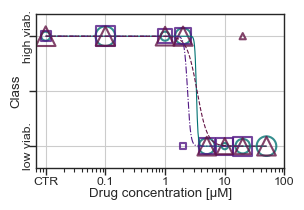

In [18]:
df = df_A673.copy()
kws_dict = kws_dict_A673
num_classes = 2

title = f'A673 True dose response curve - real {num_classes} class'

fig, ax = plt.subplots(1, 1, figsize=(3.2, 2))
group=df['Experiment ID'].unique()
test_index_list = []
y_pred_list = []

for exp in df['Experiment ID'].unique():
    df_filt = df[df['Experiment ID'] == exp]

    indices = df_filt.index.tolist()
    test_index_list.append(indices)
    
    y = df_filt[f'{num_classes} classes encoded'].tolist()
    y_pred_list.append(y)

plot_dose_response_IC50(ax, test_index_list, y_pred_list, df, kws_dict, group)

plt.savefig(f"{fig_folder}//{title}.svg", format='svg', bbox_inches='tight', transparent=True)

#### PDX

1305


100%|██████████| 5000/5000 [00:20<00:00, 238.58it/s]


IC50:  2.087 with 95% credible interval: (1.697, 2.565)
Slope: -2.788 with 95% credible interval: (-3.962, -1.943)
Mean autocorrelation time: 28.907 steps
1806


100%|██████████| 5000/5000 [00:18<00:00, 263.62it/s]


IC50:  1.117 with 95% credible interval: (1.027, 12.084)
Slope: -18.696 with 95% credible interval: (-47.505, -0.491)
Mean autocorrelation time: 59.669 steps
2406


100%|██████████| 5000/5000 [00:20<00:00, 248.11it/s]


IC50:  1.803 with 95% credible interval: (1.350, 2.479)
Slope: -3.305 with 95% credible interval: (-5.250, -2.107)
Mean autocorrelation time: 35.490 steps


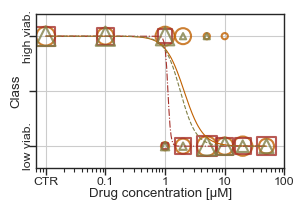

In [19]:
df = df_PDX.copy()
kws_dict = kws_dict_PDX
num_classes = 2

title = f'PDX True dose response curve - real {num_classes} class'
fig, ax = plt.subplots(1, 1, figsize=(3.2, 2))
test_index_list = []
y_pred_list = []
group=df['Experiment ID'].unique()

for exp in df['Experiment ID'].unique():
    df_filt = df[df['Experiment ID'] == exp]

    indices = df_filt.index.tolist()
    test_index_list.append(indices)
    
    y = df_filt[f'{num_classes} classes encoded'].tolist()
    y_pred_list.append(y)

plot_dose_response_IC50(ax, test_index_list, y_pred_list, df, kws_dict, group)

plt.savefig(f"{fig_folder}//{title}.svg", format='svg', bbox_inches='tight', transparent=True)

## NN model, train/test on the same dataset

#### A673

In [20]:
features_A673 = [
    'Mean grey value_day2',
    'Correlation_day2',
    'Grey2-0',
    'Growth2-0',
    'Homogeneity_day2',
    'Equivalent Diameter (um)_day2',
    'Area (um2)_day2',
    'Energy_day2',
    'Solidity_day2',
    'Circularity_day2',
    'Perimeter (um)_day2',
    'Equivalent Diameter (um)_day0',
    'Area (um2)_day0'
]

num_classes = 2

N A673 =  316
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000020161ED8540> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


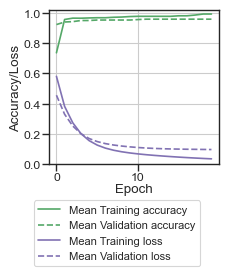

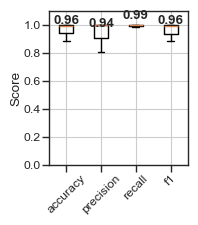

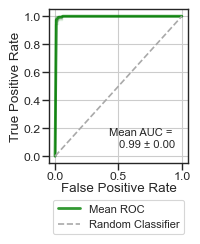

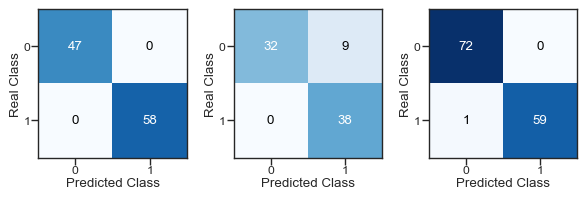

1803


100%|██████████| 5000/5000 [00:17<00:00, 290.09it/s]


IC50:  3.319 with 95% credible interval: (2.240, 4.607)
Slope: -31.682 with 95% credible interval: (-49.113, -8.915)
Mean autocorrelation time: 57.508 steps
2602


100%|██████████| 5000/5000 [00:18<00:00, 272.72it/s]


IC50:  1.658 with 95% credible interval: (1.234, 2.099)
Slope: -4.418 with 95% credible interval: (-8.978, -2.170)
Mean autocorrelation time: 34.887 steps
2901


100%|██████████| 5000/5000 [00:20<00:00, 247.31it/s]


IC50:  3.569 with 95% credible interval: (2.743, 4.620)
Slope: -2.981 with 95% credible interval: (-4.462, -1.914)
Mean autocorrelation time: 44.291 steps


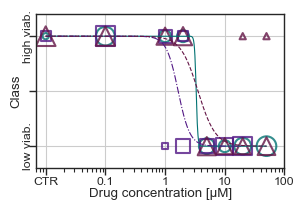

In [21]:
df = df_A673.copy()
kws_dict = kws_dict_A673
features = features_A673
title = f'A673 - {num_classes} classes - NN - {len(features)} features'

df = df.dropna(subset=features).reset_index(drop=True)
model, initial_weights = createNN_model(len(features))
print('N A673 = ', len(df))

y = df[f'{num_classes} classes encoded']
X = df[features]
group = df['Experiment ID']

(metrics_dict, conf_matrices, histories, y_test_list,
     y_pred_list, test_index_list, y_pred_proba_list, group_test) = classification_cross_validatation(model, X, y, 
                                            validation_method='leaveOneOut', group=group, NN=True,
                                        initial_weights=initial_weights)

plot_save_all_figures_ML(title, metrics_dict, conf_matrices, histories, y_test_list, y_pred_list, test_index_list, y_pred_proba_list, group_test, df, num_classes, kws_dict)

#### PDX

In [22]:
features_PDX = [
        'Mean grey value_day1',
    'Mean grey value_day2',
    'Grey1-0',
    'Grey2-0',
    'Correlation_day1',
    'Correlation_day2',
    'Solidity_day2',
    'Circularity_day2',
    'Circularity_day1',
    'Perimeter (um)_day2',
    'Solidity_day1',
    'Grey2-1',
    'Perimeter (um)_day1',
    'Area (um2)_day2',
    'Equivalent Diameter (um)_day2'
]

num_classes = 2



N PDX =  428
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


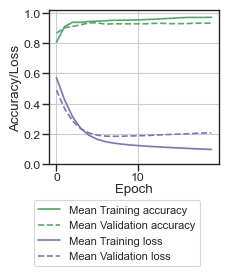

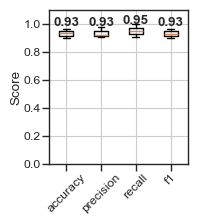

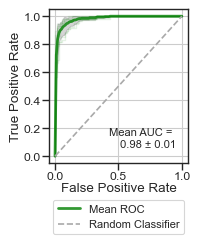

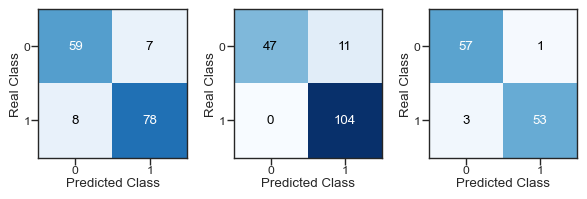

1305


100%|██████████| 5000/5000 [00:21<00:00, 231.48it/s]


IC50:  1.801 with 95% credible interval: (1.114, 2.755)
Slope: -1.069 with 95% credible interval: (-1.485, -0.750)
Mean autocorrelation time: 30.277 steps
1806


100%|██████████| 5000/5000 [00:20<00:00, 247.46it/s]


IC50:  0.404 with 95% credible interval: (0.231, 0.961)
Slope: -1.688 with 95% credible interval: (-37.111, -1.182)
Mean autocorrelation time: 51.675 steps
2406


100%|██████████| 5000/5000 [00:18<00:00, 265.17it/s]


IC50:  2.140 with 95% credible interval: (1.543, 2.942)
Slope: -3.332 with 95% credible interval: (-5.283, -2.149)
Mean autocorrelation time: 42.635 steps


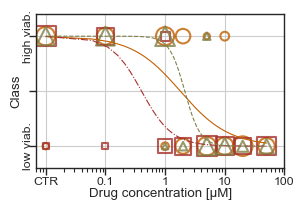

In [23]:
df = df_PDX.copy()
kws_dict = kws_dict_PDX
features = features_PDX
title = f'PDX - {num_classes} classes - NN - {len(features)} features'

df = df.dropna(subset=features).reset_index(drop=True)

print('N PDX = ', len(df))

y = df[f'{num_classes} classes encoded']
X = df[features]
group = df['Experiment ID']

model, initial_weights = createNN_model(len(features))

(metrics_dict, conf_matrices, histories, y_test_list,
     y_pred_list, test_index_list, y_pred_proba_list, group_test) = classification_cross_validatation(model, X, y, 
                                     validation_method='leaveOneOut', group=group, NN=True,
                                        initial_weights=initial_weights)
                                        
plot_save_all_figures_ML(title, metrics_dict, conf_matrices, histories, y_test_list, y_pred_list, test_index_list, y_pred_proba_list, group_test, df, num_classes, kws_dict)

## NN model, train A673 test PDX

In [24]:
def classification_cross_validatation_fixed_Xtrain(
    model, 
    training_set, 
    test_set, 
    features,           # List of feature names, corresponding to columns names of the datasets
    target_column,      # Column name for target labels
    group_column,       # Column name for groups labels
    NN=False, 
    initial_weights=[], 
    epoch=20, 
    batch_size=30, 
    ):
    
    # Prepare the training and test data
    X_train = training_set[features]
    X_test = test_set[features]
    y_train = training_set[target_column]
    y_test = test_set[target_column]
    
    # Extract unique groups labels from the test set
    groups = test_set[group_column].unique()

    # Standardize the training data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)

    # Initialize storage for metrics and predictions
    metrics_dict = {'accuracy_scores': [], 'precision_scores': [], 'recall_scores': [], 'f1_scores': []}
    conf_matrices, histories = [], []
    y_test_list, y_pred_list, test_index_list, y_pred_proba_list, group_test_list = [], [], [], [], []
    
    for group in groups:   
        # Select the test samples for the current dataset
        index_group = test_set[test_set[group_column] == group].index
        X_test_group = X_test.loc[index_group]
        y_test_group = y_test.loc[index_group]

        # Standardize the current test data
        X_test_group = scaler.transform(X_test_group)

        ### Training of the NN
        if NN == True:
            history, y_pred, y_pred_proba = _train_neural_network(
                model, X_train, y_train, X_test_group, y_test_group, num_classes, epoch, batch_size, initial_weights
            )
            histories.append(history)
        
        ### Training of model other than NN
        else : 
            y_pred, y_pred_proba = _train_standard_model(model, X_train, y_train, X_test_group)

        ### Compute metrics
        metrics_dict, conf_matrices = _save_computed_metrics(metrics_dict, conf_matrices, y_test_group, y_pred, num_classes)

        ### Append predictions and test indices
        y_test_list.append(np.array(y_test_group))   
        test_index_list.append(index_group)
        y_pred_list.append(np.array(y_pred))
        y_pred_proba_list.append(y_pred_proba)
        group_test_list.append(group)
    

    return (metrics_dict, conf_matrices, histories, y_test_list, y_pred_list, test_index_list,
            y_pred_proba_list, group_test_list)

In [25]:
num_classes = 2
features = features_PDX
model, initial_weights = createNN_model(len(features))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


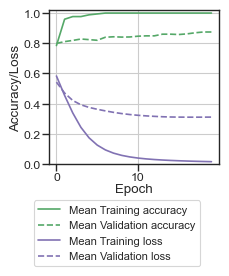

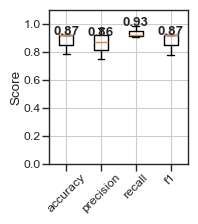

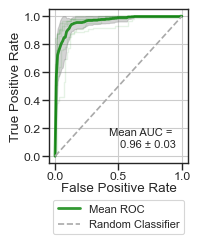

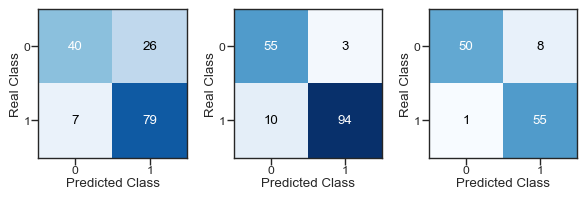

1305


100%|██████████| 5000/5000 [00:20<00:00, 245.22it/s]


IC50:  0.323 with 95% credible interval: (0.127, 0.684)
Slope: -0.574 with 95% credible interval: (-0.773, -0.400)
Mean autocorrelation time: 31.938 steps
1806


100%|██████████| 5000/5000 [00:21<00:00, 237.03it/s]


IC50:  1.569 with 95% credible interval: (1.084, 2.124)
Slope: -1.979 with 95% credible interval: (-2.897, -1.327)
Mean autocorrelation time: 30.759 steps
2406


100%|██████████| 5000/5000 [00:18<00:00, 265.33it/s]


IC50:  1.055 with 95% credible interval: (0.622, 1.682)
Slope: -1.303 with 95% credible interval: (-1.944, -0.873)
Mean autocorrelation time: 51.425 steps


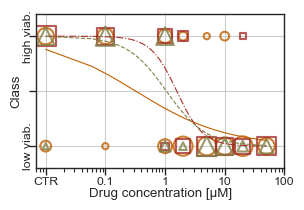

In [26]:
training_set = df_A673.copy()
test_set = df_PDX.copy()
kws_dict = kws_dict_PDX
title = f'Train A673 Test PDX - {num_classes} classes - NN - {len(features)} features'

training_set = training_set.dropna(subset=features).reset_index(drop=True)
test_set = test_set.dropna(subset=features).reset_index(drop=True)

target_column = f'{num_classes} classes encoded'
group_column = 'Experiment ID'

(metrics_dict, conf_matrices, histories, y_test_list, y_pred_list, test_index_list,
            y_pred_proba_list, group_test) = classification_cross_validatation_fixed_Xtrain(model, training_set, test_set, features_PDX, target_column, group_column,
                                      NN=True, initial_weights=initial_weights, epoch=20, batch_size=30)

plot_save_all_figures_ML(title, metrics_dict, conf_matrices, histories, y_test_list, y_pred_list, test_index_list, y_pred_proba_list, group_test, test_set, num_classes, kws_dict)

## Dynamic analysis

#### A673

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1803


100%|██████████| 5000/5000 [00:18<00:00, 266.92it/s]


IC50:  3.318 with 95% credible interval: (2.479, 4.275)
Slope: -4.230 with 95% credible interval: (-7.093, -2.437)
Mean autocorrelation time: 44.203 steps
2602


100%|██████████| 5000/5000 [00:16<00:00, 295.71it/s]


IC50:  3.396 with 95% credible interval: (2.256, 4.633)
Slope: -31.811 with 95% credible interval: (-49.195, -8.651)
Mean autocorrelation time: 56.814 steps


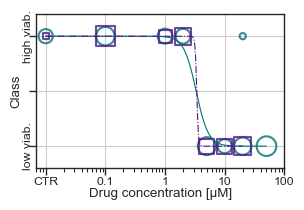

In [27]:
df = df_A673.copy()

kws_dict = kws_dict_A673

num_classes = 2

features = ['Area (um2)', 'Mean grey value', 'Homogeneity', 'Energy',
       'Correlation', 'Solidity', 'Circularity', 'Equivalent Diameter (um)',
       'Perimeter (um)', 'Growth', 'Grey', 
       #'DCorrelation',
       'Area (um2)_day0', 'Mean grey value_day0', 'Homogeneity_day0', 'Energy_day0',
       'Correlation_day0', 'Solidity_day0', 'Circularity_day0', 'Equivalent Diameter (um)_day0',
       'Perimeter (um)_day0'
       ]

title = f'Train A673 day 2 Test A673 day 1 - {num_classes} classes - NN - {len(features)} features'

df_day1 = df.copy()
columns_to_drop = df_day1.filter(regex=r'(day2$|2-0$|2-1$)').columns
df_day1 = df_day1.drop(columns=columns_to_drop)
df_day1 = df_day1.rename(columns=lambda col: col.replace('_day1', '').replace('_1-0', '').replace('1-0', ''))
df_day1 = df_day1.dropna(subset=features).reset_index(drop=True)

df_day2 = df.copy()
columns_to_drop = df_day2.filter(regex=r'(day1$|1-0$|2-1$)').columns
df_day2 = df_day2.drop(columns=columns_to_drop)
df_day2 = df_day2.rename(columns=lambda col: col.replace('_day2', '').replace('_2-0', '').replace('2-0', ''))
df_day2 = df_day2.dropna(subset=features).reset_index(drop=True)

model, initial_weights = createNN_model(len(features))

(metrics_dict, conf_matrices, histories, y_test_list, y_pred_list, test_index_list,
            y_pred_proba_list, group_test) = classification_cross_validatation_fixed_Xtrain(model, 
    training_set=df_day2, test_set=df_day1, features=features, target_column=f'{num_classes} classes encoded',
    group_column='Experiment ID', NN=True, initial_weights=initial_weights, epoch=20, batch_size=30) 

"""plot_save_all_figures_ML(title, metrics_dict, conf_matrices, histories, y_test_list, y_pred_list, test_index_list, y_pred_proba_list, group_test, 
                            df_day1, num_classes, kws_dict)"""

fig, ax = plt.subplots(1, 1, figsize=(3.2, 2))
plot_dose_response_IC50(ax, test_index_list, y_pred_list, df_day1, kws_dict, group_test)
plt.savefig(f"{fig_folder}//IC50pred_{title}.svg", format='svg', bbox_inches='tight', transparent=True)
plt.show()


#### PDX

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1305


100%|██████████| 5000/5000 [00:20<00:00, 242.29it/s]


IC50:  5.690 with 95% credible interval: (4.311, 7.543)
Slope: -1.870 with 95% credible interval: (-2.539, -1.326)
Mean autocorrelation time: 28.389 steps
1806


100%|██████████| 5000/5000 [00:20<00:00, 241.37it/s]


IC50:  3.900 with 95% credible interval: (3.081, 4.833)
Slope: -2.842 with 95% credible interval: (-4.101, -1.956)
Mean autocorrelation time: 32.323 steps
2406


100%|██████████| 5000/5000 [00:19<00:00, 262.90it/s]


IC50:  3.320 with 95% credible interval: (2.377, 4.421)
Slope: -2.830 with 95% credible interval: (-4.350, -1.838)
Mean autocorrelation time: 30.900 steps


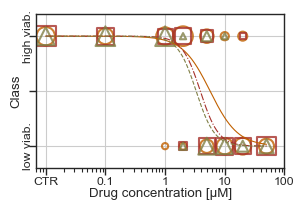

In [28]:
df = df_PDX.copy()

kws_dict = kws_dict_PDX
title = f'Train PDX day 2 Test PDX day 1 - {num_classes} classes - NN - {len(features)} features'
num_classes = 2

features = ['Area (um2)', 'Mean grey value', 'Homogeneity', 'Energy',
       'Correlation', 'Solidity', 'Circularity', 'Equivalent Diameter (um)',
       'Perimeter (um)', 'Growth', 'Grey', 
       'Area (um2)_day0', 'Mean grey value_day0', 'Homogeneity_day0', 'Energy_day0',
       'Correlation_day0', 'Solidity_day0', 'Circularity_day0', 'Equivalent Diameter (um)_day0',
       'Perimeter (um)_day0'
       ]

df_day1 = df.copy()
columns_to_drop = df_day1.filter(regex=r'(day2$|2-0$|2-1$)').columns
df_day1 = df_day1.drop(columns=columns_to_drop)
df_day1 = df_day1.rename(columns=lambda col: col.replace('_day1', '').replace('_1-0', '').replace('1-0', ''))
df_day1 = df_day1.dropna(subset=features).reset_index(drop=True)

df_day2 = df.copy()
columns_to_drop = df_day2.filter(regex=r'(day1$|1-0$|2-1$)').columns
df_day2 = df_day2.drop(columns=columns_to_drop)
df_day2 = df_day2.rename(columns=lambda col: col.replace('_day2', '').replace('_2-0', '').replace('2-0', ''))
df_day2 = df_day2.dropna(subset=features).reset_index(drop=True)

model, initial_weights = createNN_model(len(features))

(metrics_dict, conf_matrices, histories, y_test_list, y_pred_list, test_index_list,
            y_pred_proba_list, group_test) = classification_cross_validatation_fixed_Xtrain(model, 
    training_set=df_day2, test_set=df_day1, features=features, target_column=f'{num_classes} classes encoded',
    group_column='Experiment ID', NN=True, initial_weights=initial_weights, epoch=20, batch_size=30) 

"""plot_save_all_figures_ML(title, metrics_dict, conf_matrices, histories, y_test_list, y_pred_list, test_index_list, y_pred_proba_list, group_test, 
                            df_day1, num_classes, kws_dict)"""
fig, ax = plt.subplots(1, 1, figsize=(3.2, 2))
plot_dose_response_IC50(ax, test_index_list, y_pred_list, df_day1, kws_dict, group_test)
plt.savefig(f"{fig_folder}//IC50pred_{title}.svg", format='svg', bbox_inches='tight', transparent=True)
plt.show()

## Comparison of ML models

In [29]:
def plot_grouped_metrics(metrics_dicts, size=(5, 3), key='f1_scores', widths=0.7):
    # Determine the number of groups to plot
    num_groups = len(metrics_dicts)

    # Create subplots, one for each group in metrics_dicts
    fig, axes = plt.subplots(1, num_groups, figsize=size, sharey=True)

    # Loop through each metrics dictionary and its corresponding axis
    for i, (label, ax) in enumerate(zip(metrics_dicts.keys(),axes)):

        # Call plot_BoxPlot_Metrics to plot the specified metric
        plot_BoxPlot_Metrics(ax, metrics_dicts[label], keys=[key], widths=widths)
        

        ### Customize plot appearance
        # X label
        ax.set_xticklabels([label])

        # Plot all subplots as if it was only one plot
        if i > 0:
            ax.spines['left'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.set_yticklabels([])
            ax.set_ylabel('')
            ax.tick_params(axis='y', which='major', length=0)

        if i == len(metrics_dicts) - 1:
            ax.spines['right'].set_visible(True)

        if i == 0:
            ax.set_ylabel('f1-score')
            ax.spines['right'].set_visible(False)
        
    plt.subplots_adjust(wspace=-0.1)
    

In [30]:
# Hyperparameter grid for different models
models_param_grid = {
    'svc' : {
        'C': [0.1, 1, 10],                                  # Possible values for regularization parameter C
        'kernel': ['linear', 'rbf'],                        # Types of kernels to use
        'gamma': [10, 1, 0.1, 0.01]                         # Possible values for the gamma parameter (for rbf kernel)
        # 'degree': [2, 3, 4],                                # Degree of the polynomial kernel (only if kernel='poly')
        # 'coef0': [0.0, 0.1, 0.5]                            # Used for 'poly' and 'sigmoid' kernels
    },
    
    'knn' : {
        'n_neighbors': [3, 5, 7, 9, 11, 13, 15],            # Number of neighbors to use in the classifier
        'weights': ['uniform', 'distance'],                 # Weighting method for neighbors ('uniform' or 'distance')
        'metric': ['euclidean', 'manhattan']                # Distance metrics to use ('euclidean' or 'manhattan')
    },
    
    'gnb' : {
        'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]  # Smoothing parameter for Gaussian Naive Bayes
    },
    
    'dtc': {
        'criterion': ['gini', 'entropy'],                   # Splitting criteria for the decision tree ('gini' or 'entropy')
        'max_depth': [None, 10, 20, 30],                    # Maximum depth of the tree (None for unlimited depth)
        'min_samples_split': [2, 5, 10],                    # Minimum number of samples required to split a node
        'min_samples_leaf': [1, 2, 5],                      # Minimum number of samples required to be at a leaf node
        # 'max_features': [None, 'auto', 'sqrt', 'log2']     # Number of features to consider at each split
    },
    
    'rf' : {
        'n_estimators': [50, 100, 150, 200],                # Number of trees in the random forest
        # 'criterion': ['gini', 'entropy'],                   # Splitting criteria for random forest trees
        'max_depth': [None, 3, 6, 9],                       # Maximum depth of the trees
        'min_samples_split': [2, 5, 10],                    # Minimum number of samples required to split a node
        'min_samples_leaf': [1, 2, 5],                      # Minimum number of samples required at a leaf node
        'max_features': [None, 'sqrt', 'log2'],             # Number of features to consider for each split
        # 'bootstrap': [True, False]                          # Whether to use bootstrap sampling (True/False)
    },
    
    'logreg' : {
        'penalty': ['l2', None],                            # Regularization penalty: 'l2' or no regularization (None)
        'C': [0.001, 0.01, 0.1, 1, 10, 100],                # Inverse of regularization strength
        'max_iter': [100, 200, 300],                        # Maximum number of iterations for the solver
        'solver': ['lbfgs']                                 # Solver to use ('lbfgs' supports 'l2' regularization)
    }
}

# Dictionary of model instances
models_dict = {
    'svc' : SVC(),                                 # Support Vector Classifier
    'knn' : KNeighborsClassifier(),                # k-Nearest Neighbors Classifier
    'gnb' : GaussianNB(),                          # Gaussian Naive Bayes Classifier
    'dtc' : DecisionTreeClassifier(),              # Decision Tree Classifier
    'rf': RandomForestClassifier(),                # Random Forest Classifier
    'logreg' : LogisticRegression()                # Logistic Regression Classifier
}



In [31]:
def optimization_parameters(df, X, y, model, param_grid, groups):
    # Use LeaveOneGroupOut cross-validation 
    logo = LeaveOneGroupOut()
    
    # Add scaling option to the parameter grid, including the StandardScaler and the 'passthrough' option
    param_grid = {'scaler': [StandardScaler()],
                  # Includes two scalers + option to not scale the data
                  **{f'model__{key}': value for key, value in param_grid.items()}
    }

    # Create a pipeline with a scaler and the model
    pipeline = Pipeline([('scaler', 'passthrough'), ('model', model)])
    
    # Setup GridSearchCV with the pipeline, parameter grid, and cross-validation strategy
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=logo, scoring='accuracy', n_jobs=-1)

    # Fit the model using the provided data and group splits
    grid_search.fit(X, y, groups=groups)

    # Retrieve and display the best hyperparameters and corresponding accuracy score
    print("Model :", model.__class__.__name__)
    print("Best mean accuracy : {:.2f}%".format(grid_search.best_score_ * 100))
    print("Best hyperparameters :", grid_search.best_params_, "\n")
    
    # Extract the best model (the one with the best hyperparameters) from the grid search
    best_model = grid_search.best_estimator_.named_steps['model']
    
    # Return the best model
    return best_model

In [32]:
def multiple_model_comparison(df, title, features, target_column, group_column, models_labels, models_dict=models_dict, models_param_grid=models_param_grid):
    df = df.dropna(subset=features).reset_index(drop=True)
    
    X = df[features]
    y = df[target_column]
    group = df[group_column]

    # Initialize an empty dictionary to store the performance metrics for each model
    metrics_dicts = {}

    ### Train/test models (others than NN)
    for model_id in models_labels:
        # Retrieve the model and its corresponding parameter grid
        model = models_dict[model_id]
        param_grid = models_param_grid[model_id]

        # Optimize the model parameters using grid search and cross-validation
        best_params = optimization_parameters(df, X, y, model, param_grid, groups=group)

        # Update the model with the best parameters found
        model_opti = best_params
        
        # Run the model
        metrics_dict_model, _, _, _, _, _, _, _ = classification_cross_validatation(model_opti, X, y, 
                                        validation_method='leaveOneOut', group=group, NN=False)

        # Store the metrics for the model in the dictionary
        metrics_dicts[model_id] = metrics_dict_model
  
    ### Train/test NN model
    NN_model, initial_weights = createNN_model(len(features))

    # Run the model for NN
    metrics_dict_model, _, _, _, _, _, _, _ = classification_cross_validatation(NN_model, X, y, 
                                        validation_method='leaveOneOut', group=group, NN=True,
                                            initial_weights=initial_weights)

    # Store metrics for NN
    metrics_dicts['NN'] = metrics_dict_model

    ### Plot the f1-score for all models
    plot_grouped_metrics(metrics_dicts, size=(5, 3))

    ### Save figure
    plt.savefig(f"{fig_folder}//{title}.svg", format='svg', bbox_inches='tight', transparent=True)
    plt.show()

### A673

Model : SVC
Best mean accuracy : 97.74%
Best hyperparameters : {'model__C': 0.1, 'model__gamma': 10, 'model__kernel': 'linear', 'scaler': StandardScaler()} 

Model : KNeighborsClassifier
Best mean accuracy : 96.05%
Best hyperparameters : {'model__metric': 'manhattan', 'model__n_neighbors': 5, 'model__weights': 'uniform', 'scaler': StandardScaler()} 

Model : GaussianNB
Best mean accuracy : 95.21%
Best hyperparameters : {'model__var_smoothing': 1e-09, 'scaler': StandardScaler()} 

Model : DecisionTreeClassifier
Best mean accuracy : 96.52%
Best hyperparameters : {'model__criterion': 'gini', 'model__max_depth': None, 'model__min_samples_leaf': 2, 'model__min_samples_split': 10, 'scaler': StandardScaler()} 

Model : RandomForestClassifier
Best mean accuracy : 96.52%
Best hyperparameters : {'model__max_depth': None, 'model__max_features': None, 'model__min_samples_leaf': 5, 'model__min_samples_split': 10, 'model__n_estimators': 150, 'scaler': StandardScaler()} 



c:\Users\MMBM_JOSQUIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\MMBM_JOSQUIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\MMBM_JOSQUIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\MMBM_JOSQUIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


Model : LogisticRegression
Best mean accuracy : 96.83%
Best hyperparameters : {'model__C': 0.001, 'model__max_iter': 100, 'model__penalty': None, 'model__solver': 'lbfgs', 'scaler': StandardScaler()} 

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


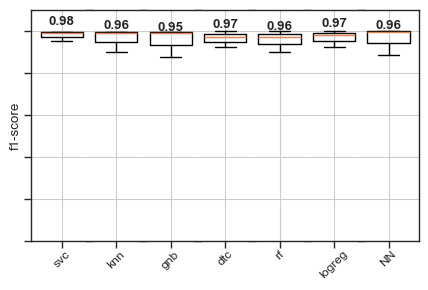

In [33]:
df = df_A673.copy()
features = features_A673
title = 'SX_comp_models_A673'

num_classes = 2
target_column = f'{num_classes} classes encoded'
group_column = 'Experiment ID'
models_labels = ['svc', 'knn', 'gnb', 'dtc', 'rf', 'logreg']

multiple_model_comparison(df, title, features, target_column, group_column, models_labels, models_dict=models_dict, models_param_grid=models_param_grid)


### PDX

Model : SVC
Best mean accuracy : 93.13%
Best hyperparameters : {'model__C': 0.1, 'model__gamma': 0.01, 'model__kernel': 'rbf', 'scaler': StandardScaler()} 

Model : KNeighborsClassifier
Best mean accuracy : 93.48%
Best hyperparameters : {'model__metric': 'manhattan', 'model__n_neighbors': 13, 'model__weights': 'uniform', 'scaler': StandardScaler()} 

Model : GaussianNB
Best mean accuracy : 93.40%
Best hyperparameters : {'model__var_smoothing': 1e-09, 'scaler': StandardScaler()} 

Model : DecisionTreeClassifier
Best mean accuracy : 92.11%
Best hyperparameters : {'model__criterion': 'entropy', 'model__max_depth': 10, 'model__min_samples_leaf': 5, 'model__min_samples_split': 10, 'scaler': StandardScaler()} 



c:\Users\MMBM_JOSQUIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Model : RandomForestClassifier
Best mean accuracy : 95.08%
Best hyperparameters : {'model__max_depth': 6, 'model__max_features': 'log2', 'model__min_samples_leaf': 5, 'model__min_samples_split': 2, 'model__n_estimators': 50, 'scaler': StandardScaler()} 

Model : LogisticRegression
Best mean accuracy : 93.54%
Best hyperparameters : {'model__C': 0.01, 'model__max_iter': 100, 'model__penalty': 'l2', 'model__solver': 'lbfgs', 'scaler': StandardScaler()} 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


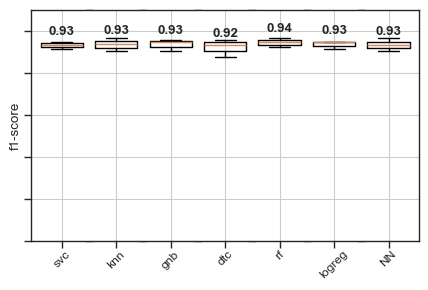

In [34]:
df = df_PDX.copy()
features = features_PDX
title = 'SX_comp_models_PDX'

num_classes = 2
target_column = f'{num_classes} classes encoded'
group_column = 'Experiment ID'
models_labels = ['svc', 'knn', 'gnb', 'dtc', 'rf', 'logreg']

multiple_model_comparison(df, title, features, target_column, group_column, models_labels, models_dict=models_dict, models_param_grid=models_param_grid)

### Train on A673, test on PDX

Model : SVC
Best mean accuracy : 97.95%
Best hyperparameters : {'model__C': 0.1, 'model__gamma': 10, 'model__kernel': 'linear', 'scaler': StandardScaler()} 

Model : KNeighborsClassifier
Best mean accuracy : 99.32%
Best hyperparameters : {'model__metric': 'manhattan', 'model__n_neighbors': 3, 'model__weights': 'uniform', 'scaler': StandardScaler()} 

Model : GaussianNB
Best mean accuracy : 95.89%
Best hyperparameters : {'model__var_smoothing': 1e-09, 'scaler': StandardScaler()} 

Model : DecisionTreeClassifier
Best mean accuracy : 96.07%
Best hyperparameters : {'model__criterion': 'gini', 'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'scaler': StandardScaler()} 

Model : RandomForestClassifier
Best mean accuracy : 100.00%
Best hyperparameters : {'model__max_depth': None, 'model__max_features': 'log2', 'model__min_samples_leaf': 5, 'model__min_samples_split': 5, 'model__n_estimators': 100, 'scaler': StandardScaler()} 

Model : LogisticRegression


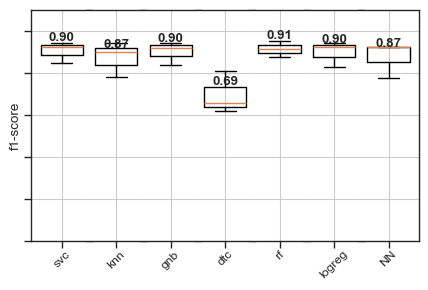

In [35]:
training_set = df_A673.copy()
test_set = df_PDX.copy()

title = 'SX_comp_models_train_A673__test_PD'
features = features_PDX
num_classes = 2

training_set = training_set.dropna(subset=features).reset_index(drop=True)
test_set = test_set.dropna(subset=features).reset_index(drop=True)

target_column = f'{num_classes} classes encoded'
group_column = 'Experiment ID'

groups = training_set[group_column]
exps = test_set[group_column].unique()

models_labels = ['svc', 'knn', 'gnb', 'dtc', 'rf', 'logreg']

X_train = training_set[features]
y_train = training_set[target_column]

metrics_dicts = {}

for model_id in models_labels:
    model = models_dict[model_id]
    param_grid = models_param_grid[model_id]

    best_params = optimization_parameters(training_set, X_train, y_train, model, param_grid, groups=groups)
    
    model_opti = best_params

    metrics_dict, _, _, _, _, _, _, _ = classification_cross_validatation_fixed_Xtrain(model_opti, training_set, test_set, 
                                                                features, target_column, group_column, NN=False)
    
    metrics_dicts[model_id] = metrics_dict

    
model, initial_weights = createNN_model(len(features))

metrics_dict, _, _, _, _, _, _, _ = classification_cross_validatation_fixed_Xtrain(model, training_set, test_set, 
                                                                features, target_column, group_column, NN=True, initial_weights=initial_weights)

metrics_dicts ['NN'] = metrics_dict


plot_grouped_metrics(metrics_dicts)

plt.savefig(f"{fig_folder}//{title}.svg", format='svg', bbox_inches='tight', transparent=True)
plt.show()